In [22]:
import os


TiposDeSenales = []

# Obtener todos los nombres de las carpetas de los tipos de señales
for a in carpetas:
    nombres = os.listdir(a)
    TiposDeSenales.extend(nombres)


def getSignalDir(i:int):
    return carpetas[int(TiposDeSenales[i][1])-1] +'/'+ TiposDeSenales[i]

def getSignalLis(i:int):
    return os.listdir(getSignalDir(i))


for i, b in enumerate(TiposDeSenales):
    print(TiposDeSenales[i],":  ",len(getSignalDir(i)))



0101-Parada_De_Bus :   38
0102-Zona_De_Encuentro :   42
0201-No_Pase :   31
0202-No_Parqueo :   34
0203-Pare :   28
0204-No_Girar_U :   34
0205-Prohibido_Parquear :   42
0206-Ceda_El_Paso :   36
0207-Prohibido_Girar_Derecha :   47
0208-Prohibido_Girar_Izquierda :   49
0209-Un_Solo_Sentido :   39
0210-Deteccion_Electronica :   45
0211-Prohibido_Dejar_Pasajeros :   49
0212-Velocidad_Maxima :   40
0213-Maltrato_Animal :   39
0214-No_Parqueo_Deteccion :   44
0301-Arroyo :   27
0302-Tráfico_Bicicletas :   39
0303-Zona_De_Peatones :   37
0304-Reductor_De_Velocidad :   42
0305-Zona_Escolar :   33


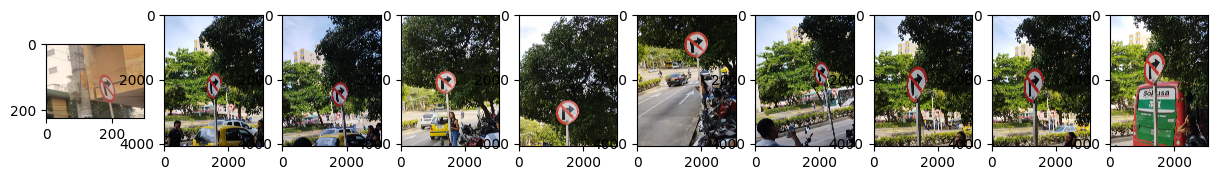

In [23]:
import matplotlib.pyplot as plt
import matplotlib.image as mping

plt.figure(figsize=(15,15))


imagenes = getSignalLis(8)

for i , nombreimg in enumerate(imagenes[:10]):
  plt.subplot(1,10,i+1)
  img = mping.imread(getSignalDir(8) + "/" + nombreimg)
  plt.imshow(img)


In [34]:
import shutil

for i in range(len(TiposDeSenales)):
    imagenes = getSignalLis(i)

    if len(imagenes) < 20:
        print("Imagenes Insuficientes: " + TiposDeSenales[i] + " -> " + str(len(imagenes)))
        continue
    
    for j, nombreimg in enumerate(imagenes):

        directorio = "train/" + TiposDeSenales[i][:2] + TiposDeSenales[i][2:4]

        os.makedirs(directorio, exist_ok=True)
        shutil.copy(getSignalDir(i) + "/" + nombreimg, directorio)

Imagenes Insuficientes: 0201-No_Pase -> 8
Imagenes Insuficientes: 0209-Un_Solo_Sentido -> 2
Imagenes Insuficientes: 0211-Prohibido_Dejar_Pasajeros -> 12
Imagenes Insuficientes: 0212-Velocidad_Maxima -> 6
Imagenes Insuficientes: 0301-Arroyo -> 7
Imagenes Insuficientes: 0304-Reductor_De_Velocidad -> 12


In [42]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np


datagen = ImageDataGenerator(
    rescale = 1. / 255,
    rotation_range = 30,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 15,
    zoom_range = [0.5, 1.15],
    validation_split = 0.3,
)

dataGenEntrenamiento = datagen.flow_from_directory( 'train', target_size = (224,224), batch_size = 32, shuffle = True, subset = "training")
dataGenValidacion = datagen.flow_from_directory( 'train', target_size = (224,224), batch_size = 32, shuffle = True, subset = "validation")

Found 406 images belonging to 15 classes.
Found 167 images belonging to 15 classes.


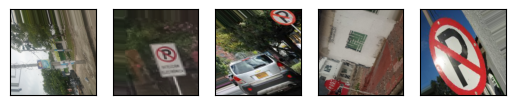

In [43]:
import matplotlib.pyplot as plt
for imagen, etiqueta in dataGenEntrenamiento:
  for i in range(5):
    plt.subplot(1,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(imagen[i])
  break

  plt.show()

In [47]:
import tensorflow as tf
# Cargar el modelo MobileNetV2 preentrenado de TensorFlow
mobilenetv2_base = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Congelar las capas del modelo base
mobilenetv2_base.trainable = False

# Definir la entrada
inputs = tf.keras.Input(shape=(224, 224, 3))

# Pasar la entrada a través del modelo base
x = mobilenetv2_base(inputs, training=False)

# Añadir una capa de aplanamiento
x = tf.keras.layers.GlobalAveragePooling2D()(x)

# Añadir la capa final
outputs = tf.keras.layers.Dense(15, activation='softmax')(x)

# Crear el modelo funcional
modelo = tf.keras.Model(inputs=inputs, outputs=outputs)

# Compilar el modelo
modelo.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# %%
modelo.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 15)             │        19,215 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,277,199 (8.69 MB)

 Trainable params: 19,215 (75.06 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [48]:
epocas = 50

historial = modelo.fit(
  dataGenEntrenamiento, epochs = epocas, batch_size = 32,
    validation_data = dataGenValidacion
)

Epoch 1/50


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


13/13 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.0947 - loss: 3.0896 - val_accuracy: 0.3293 - val_loss: 2.2906
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.3849 - loss: 2.0014 - val_accuracy: 0.4072 - val_loss: 1.8704
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.5751 - loss: 1.3722 - val_accuracy: 0.5030 - val_loss: 1.7535
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.6333 - loss: 1.1805 - val_accuracy: 0.5749 - val_loss: 1.5206
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.7380 - loss: 0.9387 - val_accuracy: 0.6168 - val_loss: 1.4226
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.7550 - loss: 0.8275 - val_accuracy: 0.6048 - val_loss: 1.4608
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.7821 - loss: 0.7642 - val_accuracy: 0.6228 - val_loss: 1.3685
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.7837 - loss: 0.7604 - val_accuracy: 0.6467 - val_loss: 1.1696
Epo

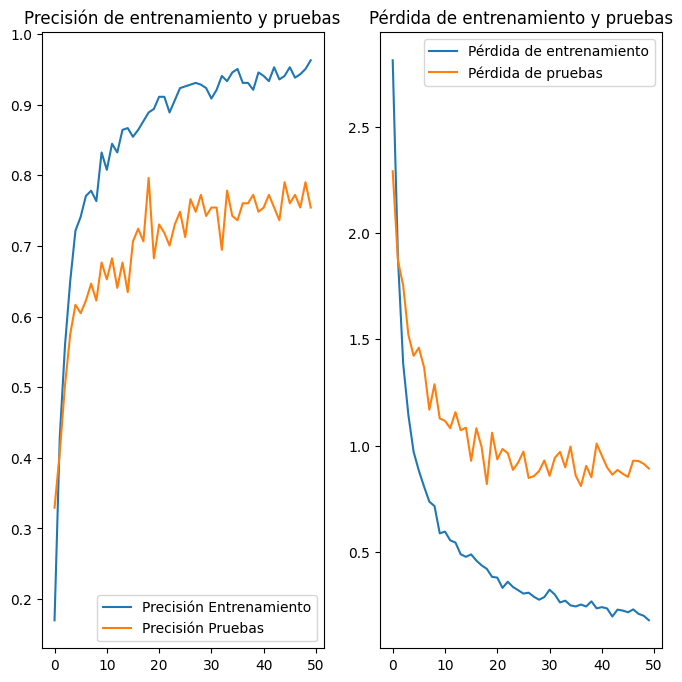

In [49]:
acc = historial.history['accuracy']

val_acc = historial.history['val_accuracy']

loss = historial.history['loss']

val_loss = historial.history['val_loss']

rango_epocas = range(50)

plt.figure(figsize=(8,8))

plt.subplot(1,2,1)

plt.plot(rango_epocas, acc, label='Precisión Entrenamiento')

plt.plot(rango_epocas, val_acc, label='Precisión Pruebas')

plt.legend(loc='lower right')

plt.title('Precisión de entrenamiento y pruebas')

plt.subplot(1,2,2)

plt.plot(rango_epocas, loss, label='Pérdida de entrenamiento')

plt.plot(rango_epocas, val_loss, label='Pérdida de pruebas')

plt.legend(loc='upper right')

plt.title('Pérdida de entrenamiento y pruebas')

plt.show()


In [51]:
modelo.save('SignalClassifier.h5')